# Analytical Interface Corrections to Ion Dissociation
Amro Dodin - UC Berkeley & LBL

In this notebook, we'll explore the impact of different interfaces on ion pair dissociation.
We'll be focusing on the dissociation of Na Cl as a prototypical example.
As a first step, we'll define the potentials of interest. 
Then, we will plot these for the dissociation of an ion pair conditioned on the anion position.

First, let's load in the required packages. We'll need the following:
    
- numpy
- matplotlib through the pyplot interface


In [229]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

from numpy import pi, exp, cos, sin, sqrt, log
from scipy.special import erf

In [230]:
plt.rc('font', size=20)

We'll also define some physical constants we'll need:

- $\epsilon_0$: Permitivitty of Free Space
- $k_B T$: Thermal energy at 300K
- $\chi_{\mathrm{water}}$: The relative susceptibility of water
- $\chi_{\mathrm{cond}}$: A fictitious susceptibility for an ideal conductor set to be very large for convenience in generating image charge positions later

In [231]:
eps_0_nat = 55.26349406     # In units of e^2 eV^-1 micron^-1
eV_to_kCal = 23             # kCal/mol eV^-1
micron_to_angstrom = 1e4    # A micron^-1
eps_0 = eps_0_nat/(eV_to_kCal*micron_to_angstrom)
kT = 0.593                  # kCal/mol
chi_water = 77.4            # Water Relative Permitivity
chi_cond = 1e12

We'll also define some Lennard-Jones parameters from Na, Cl, and Au (which we'll use for the wall).

In [232]:
epsilon_lj_Na = 0.12466
epsilon_lj_Cl = 0.12466
epsilon_lj_NaCl = sqrt(epsilon_lj_Na * epsilon_lj_Cl)
sigma_lj_Na = 2.87600
sigma_lj_Cl = 3.78500
sigma_lj_Au = 3.16435
sigma_lj_NaCl = (sigma_lj_Na + sigma_lj_Cl)/2
sigma_lj_NaAu = (sigma_lj_Na + sigma_lj_Au)/2

## Potentials

We'll be writing down a bunch of potential energy functions. To help plot them and make sure everything looks correct, it'll be helpful to generate a few sets of points to plot along. 
First, let's generate a 1D array of points along the z axis from 0 to 10 $\AA$

In [233]:
r_1D = np.zeros((100,3))
r_1D[:,2] = np.linspace(1, 10, 100)

Since we'll be interested in studying systems with an interface that breaks symmetry along one dimension, we'll also want a 2D grid of points. By convention, we'll place the interface in the $xy$ plane and use the $z$ coordinate to set the distance to the interface. We'll generate points in the interval $z\in [-10,10]$. We'll also scan along one direction parallel to the interface which we'll define as $x$ in the interval $x\in[-10, 10]$. 

In [234]:
n_x = 1000
n_z = 1000

x_min = -10
x_max = 10
z_min = -10
z_max = 10

x = np.linspace(x_min, x_max, n_x)
z = np.linspace(z_min, z_max, n_z)

X, Z = np.meshgrid(x, z)
Y = np.zeros_like(X)
r_2D = np.reshape([X, Y, Z], (3, n_x*n_z)).T


### Pair Potentials

Next let's define the potentials that will contribute to the system's potential energies. First, we'll define the Coulomb and Lennard-Jones Pair potentials.

In [235]:
def coulomb_potential(r1, r2=np.array([[0, 0, 0]]), q1=1, q2=[1], chi=0):
    E_c = 0
    prefactor = 1/(4 * pi * eps_0) * 1/(1 + chi)
    for q, ri in zip(q2, r2):
        r = np.linalg.norm(r1 - ri, axis=1)
        E_c += prefactor * q1*q/r
    return E_c

In [236]:
def lj_potential(r1, r2 = np.array([[0,0,0]]), epsilon=[epsilon_lj_NaCl], sigma=[sigma_lj_NaCl]):
    E_LJ = 0
    for e, s, ri in zip(epsilon, sigma, r2):
        r = np.linalg.norm(r1 - ri, axis=1)/s
        E_LJ += e * (r**-12 - r**-6)
    return E_LJ

Let's plot these pair potentials as a function of distance by scanning along the z axis and generate The probability distribution due to the pair potentials.

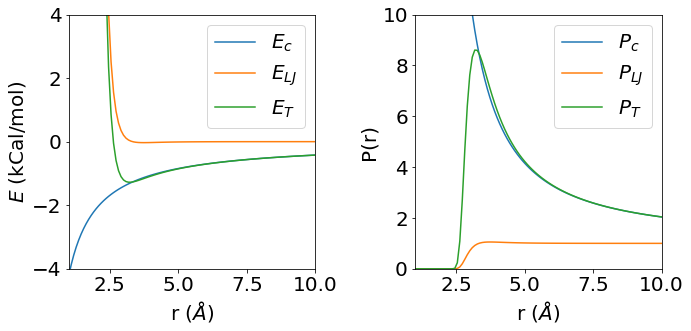

In [237]:
fig,ax = plt.subplots(1, 2, figsize=(10, 5))

V_c = coulomb_potential(r_1D,q2=[-1], chi=chi_water)
ax[0].plot(r_1D[:,2], V_c)

V_lj = lj_potential(r_1D)
ax[0].plot(r_1D[:,2], V_lj)

ax[0].plot(r_1D[:,2], V_lj+V_c)
ax[0].set_xlabel('r ($\AA$)')
ax[0].set_ylabel('$E$ (kCal/mol)')
ax[0].legend(['$E_c$', '$E_{LJ}$', '$E_T$'])

ax[0].set_xlim(1, 10)
ax[0].set_ylim(-4, 4)

p_c = np.exp(-(V_c)/kT)
p_LJ = np.exp(-V_lj/kT)
p_T = np.exp(-(V_lj+V_c)/kT)
ax[1].plot(r_1D[:,2], p_c)
ax[1].plot(r_1D[:,2], p_LJ)
ax[1].plot(r_1D[:,2], p_T)
ax[1].set_xlabel('r ($\AA$)')
ax[1].set_ylabel('P(r)')

ax[1].legend(['$P_c$', '$P_{LJ}$', '$P_T$'])

ax[1].set_xlim(1, 10)
ax[1].set_ylim(0,10)

plt.tight_layout()
plt.show()

## Wall Potentials

The next step is to implement the influence of the wall on the ion positions. The walls have two primary effects: direct repulsive effects due to a Lennard-Jones potentials and indirect coulombic effects due to the build up of charge at the dielectric continuity.

To confirm that our potentials look reasonable, we'll plot them for a wall placed at $z= 10\;\AA$ and for an anion placed at $r_{\mathrm{anion}} = (0,\, 0,\, 6.5\,\AA)$.
As a subtle point, the dielectric discontinuity actually occurs at the van der Waal's radius of the electrode and not at the center of the last layer of atom.
So we need to shift the dielectric discontinuity by this value relative to the Lennard-Jones Repulsion.


In [238]:
z_wall=10
z_dielectric = z_wall - sigma_lj_NaAu
r_an = np.array([[0, 0, 6.5]])
q_an=-1


We can easily write down the Lennard-Jones potential along any dimension by writing down a 1D potential as follows:

In [239]:
def lj_wall_potential(r_1, z_wall = 0, epsilon=epsilon_lj_NaCl, sigma=sigma_lj_NaAu, dimension=2):
    r = (r_1[:, dimension] - z_wall)/sigma
    return epsilon * (r**-12 - r**-6)

In [240]:
def hard_wall_potential(r_1, z_wall=0, sigma=sigma_lj_NaAu, dimension=2):
    return (r_1[:, dimension]>(z_wall-sigma))*1e12

Plotting the Lennard-Jones Wall Potential we see a harshly repulsive potential along $z$ with very little dispersive attraction for these parameters.

/var/folders/l1/h3x9q50j7593jnfkgtq065t80000gn/T/ipykernel_31206/1097921353.py:3: RuntimeWarning: divide by zero encountered in power
  return epsilon * (r**-12 - r**-6)
/var/folders/l1/h3x9q50j7593jnfkgtq065t80000gn/T/ipykernel_31206/1097921353.py:3: RuntimeWarning: invalid value encountered in subtract
  return epsilon * (r**-12 - r**-6)


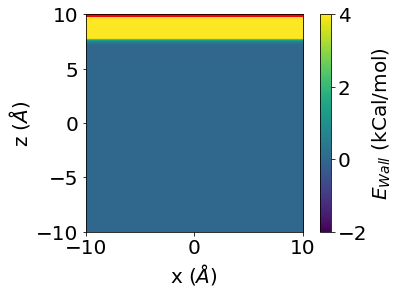

In [241]:
V_wall_2D = lj_wall_potential(r_2D, z_wall)
V_wall_2D = np.reshape(V_wall_2D, (n_x, n_z))
im = plt.imshow(V_wall_2D, extent=[x_min, x_max, z_min, z_max], origin='lower', aspect='equal', vmin=-2, vmax=4)
plt.colorbar(im, label='$E_{Wall}$ (kCal/mol)')
plt.axhline(10, c='r', lw=5)
plt.xlabel('x ($\AA$)')
plt.ylabel('z ($\AA$)')

plt.show()

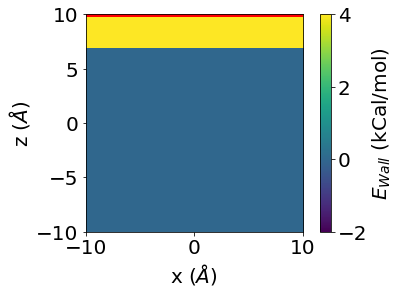

In [242]:
V_hard_wall_2D = hard_wall_potential(r_2D, z_wall)
V_hard_wall_2D = np.reshape(V_hard_wall_2D, (n_x, n_z))
im = plt.imshow(V_hard_wall_2D, extent=[x_min, x_max, z_min, z_max], origin='lower', aspect='equal', vmin=-2, vmax=4)
plt.colorbar(im, label='$E_{Wall}$ (kCal/mol)')
plt.axhline(10, c='r', lw=5)
plt.xlabel('x ($\AA$)')
plt.ylabel('z ($\AA$)')

plt.show()

Since we'll be interested in solving for planar interfaces, we can use image charge methods to quickly solve for the Coulomb potential due to the dielectric discontinuity at the interface. To do this, we need to find the image charge positions (the mirror images of the physical charges) and the charges themselves (given by $\frac{\Delta\chi}{2+\Delta\chi}q$). This will yield an attractive potential if the host dielectric is less polarizable than the other side of the interface (e.g. a liquid-conductor interface) and a repulsive one if it is more polarizable (e.g. a liquid-vapor or liquid insulator interface).

As a first step, let's build the list of image positions from a list of physical charge positions (NB: this will have to include the position of thecation itself).

In [243]:
def image_positions(r, z_int=0, dim=2):
    r_im = np.copy(r)
    r_im[:, dim] = 2*z_int - r[:,dim]
    return r_im

Plotting the physical charges in red, the interface in black and the image charges in blue we see that we've properly placed the image charges.

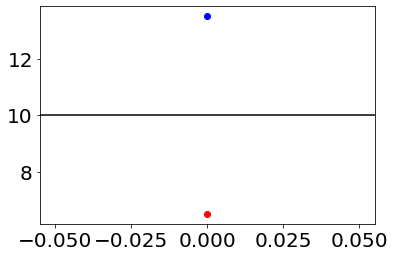

In [244]:
plt.scatter(r_an[:,0], r_an[:,2], c= 'r')
r_im = image_positions(r_an, z_wall)
plt.scatter(r_im[:,0], r_im[:,2], c= 'b')
plt.axhline(z_wall, c='k')
plt.show()

Now let's construct the list of charges for a given difference in dielectrics $\Delta \chi$

In [245]:
def image_charges(q, chi1=chi_water, chi2=0):
    deltachi = chi2 - chi1
    q_im = -q * (deltachi/(abs(deltachi)+2))
    return q_im

Let's modify the plot above so that the color of the dot reflects the charge and plot the image charge as a square.

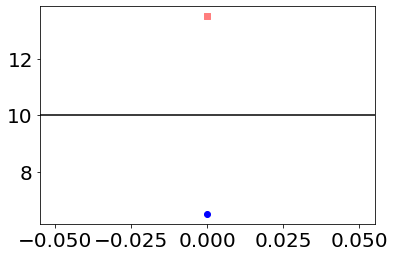

In [246]:
cmap = cm.get_cmap('bwr')
norm = Normalize(-1, 1)

q_im = image_charges(q_an, chi1=1, chi2=3)
plt.scatter(r_im[:,0], r_im[:,2], c=q_im, cmap=cmap, norm=norm, marker='s')
plt.scatter(r_an[:,0], r_an[:,2], c=q_an, cmap=cmap, norm=norm)
plt.axhline(z_wall, c='k')
plt.show()

Let's put these together to evaluate the coulomb potential at a dielectric discontinuity. First we'll generate the effect of the polarization induced by other charges.

In [247]:
def dielectric_wall_potential_other(r1, q1=1, z_wall=0, r2=np.array([[]]), q2=np.array([]), dim=2, chi1=chi_water, chi2=0):
    r_im = image_positions(r2, z_wall, dim)
    q_im = image_charges(q2, chi1,  chi2)
    r2_all = np.concatenate([r2, r_im])
    q2_all = np.concatenate([q2, q_im])
    return coulomb_potential(r1, r2=r_im, q1=q1, q2=q_im, chi=chi1)*((r1[:,dim]-z_wall) < 0)


Plotting this, for a liquid-vapor interface, we see that outside the dielectric discontinuity shown as the red dashed line, the presence of the anion induces a negative surface charge that leads to a strong attractive potential for the cation.

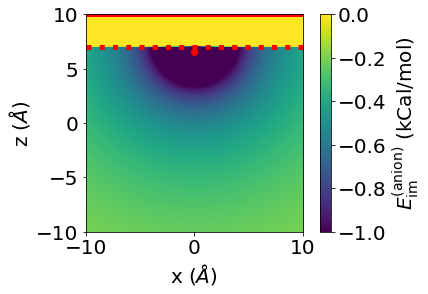

In [248]:
V_diel_2D = dielectric_wall_potential_other(r_2D, z_wall=z_dielectric, chi1=chi_water, r2=r_an, q2=np.array([-1]))
V_diel_2D = np.reshape(V_diel_2D, (n_x, n_z))
im = plt.imshow(V_diel_2D, extent=[x_min, x_max, z_min, z_max], origin='lower', aspect='equal', vmin=-1, vmax=0)
plt.colorbar(im, label='$E^{\mathrm{(anion)}}_{\mathrm{im}}$ (kCal/mol)')
plt.axhline(z_wall, c='r', lw=5)
plt.axhline(z_dielectric,c='r',ls=':', lw=5)
plt.scatter(r_an[:,0], r_an[:,2], c='r')
plt.xlabel('x ($\AA$)')
plt.ylabel('z ($\AA$)')
plt.show()

Now Let's add in the effect of the surface charge induced by the cation itself. 

In [249]:
def dielectric_wall_potential_self(r1, q1=1, z_wall=0, dim=2, chi1=chi_water, chi2=0, eta=sigma_lj_Na):
    prefactor = 1/(4 * pi * eps_0) * 1/(1 + chi1)
    z_im = image_positions(r1, z_wall, dim)[:, dim]
    q_im = image_charges(np.array([q1]), chi1, chi2)[0]
    r = r1[:, dim]-z_im
    smear = -erf(r/eta)
    #smear=1
    return -prefactor * smear*q1*q_im/r*(r1[:, dim] < z_wall)

If we plot the interaction of a particle with a planar liquid-vapor interface, we see that the particle induces a surface charge of the same sign leading to a net repulsion of the particle from the interface.

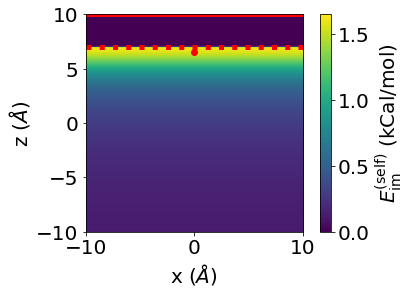

In [250]:
V_diel_self_2D = dielectric_wall_potential_self(r_2D, z_wall=z_dielectric, chi1=chi_water)
V_diel_self_2D = np.reshape(V_diel_self_2D, (n_x, n_z))
im = plt.imshow(V_diel_self_2D, extent=[x_min, x_max, z_min, z_max], origin='lower', aspect='equal', vmin=0, vmax=1.65)
plt.colorbar(im, label='$E^{\mathrm{(self)}}_{\mathrm{im}}$ (kCal/mol)')
plt.axhline(z_wall, c='r', lw=5)
plt.axhline(z_dielectric,c='r',ls=':', lw=5)
plt.scatter(r_an[:,0], r_an[:,2], c='r')
plt.xlabel('x ($\AA$)')
plt.ylabel('z ($\AA$)')
plt.show()

Putting all of this together, we can show the net effect of the interface on the ion pair displacement, for a particular anion position.

Qualitatively, we see a few important effects of this liquid-vapor interface:

1. Cations are excluded from entering the Lennard-Jones radius of the wall and experience a further repulsive potential due to dielecric confinement. This introduces an entropic penalty for more dissociated species relative to the bulk.
2. Near the interface, the cation prefers to align perpendicular, away from the interface. This is due to the surface charge induced by the two ions.
3. Coulombic attraction to the anion is enhanced due to the decreased screening near the interface. Mathematically, this appears as the induced surface charge at the dielectric discontinuity.

Collectively, these effects will stabilize contact ion pairs more than solvent separated ion pairs and both ion pairs over the dissociated state.

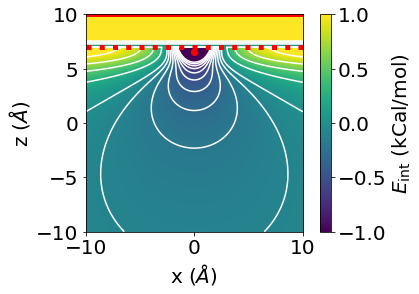

In [251]:
V_int = V_diel_self_2D + V_diel_2D + V_wall_2D
im = plt.imshow(V_int, extent=[x_min, x_max, z_min, z_max], origin='lower', aspect='equal', vmin=-1, vmax=1)
plt.contour(V_int, levels=[-1, -0.9, -0.8, -0.7,-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.25, 0.5,0.75,  1.0], colors='w', extent=[x_min, x_max, z_min, z_max], origin='lower', vmin=-1, vmax=1)
plt.colorbar(im, label='$E_{\mathrm{int}}$ (kCal/mol)')
plt.axhline(z_wall, c='r', lw=5)
plt.axhline(z_dielectric,c='r',ls=':', lw=5)
plt.scatter(r_an[:,0], r_an[:,2], c='r')
plt.xlabel('x ($\AA$)')
plt.ylabel('z ($\AA$)')
plt.show()

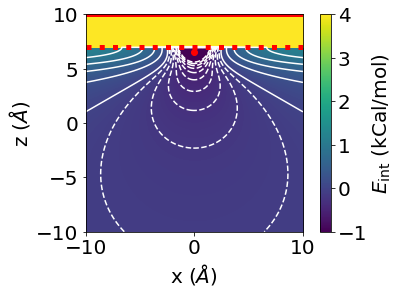

In [252]:
V_hard_int = V_diel_self_2D + V_diel_2D + V_hard_wall_2D
im = plt.imshow(V_hard_int, extent=[x_min, x_max, z_min, z_max], origin='lower', aspect='equal', vmin=-1, vmax=4)
plt.contour(V_hard_int, levels=[-1, -0.9, -0.8, -0.7,-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.25, 0.5,0.75,  1.0], colors='w', extent=[x_min, x_max, z_min, z_max], origin='lower', vmin=-1, vmax=4)
plt.colorbar(im, label='$E_{\mathrm{int}}$ (kCal/mol)')
plt.axhline(z_wall, c='r', lw=5)
plt.axhline(z_dielectric,c='r',ls=':', lw=5)
plt.scatter(r_an[:,0], r_an[:,2], c='r')
plt.xlabel('x ($\AA$)')
plt.ylabel('z ($\AA$)')
plt.show()

Repeating this procedure for a conductor instead, we can see different physics. The Lennard-Jones part of the wall potential is unchanged from what we saw above, but the effect of the induced charge at the dielectric discontinuity will be reversed.

Starting with the charge induced by the anion, we see that rather than an attractive potential, we see a repulsive one. This is because the charge induced by the anion is positive near a metal-water interface. Analogously, this can be thought of as an increased screening of the bonded interaction due to the presence of the conductor.

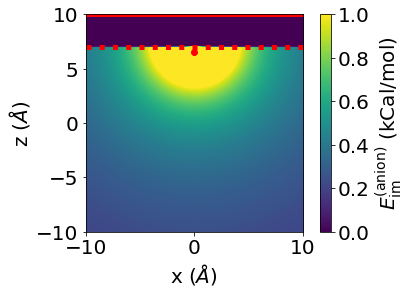

In [253]:
V_cond_2D = dielectric_wall_potential_other(r_2D, z_wall=z_dielectric, chi1=chi_water, r2=r_an, q2=np.array([-1]), chi2=chi_cond)
V_cond_2D = np.reshape(V_cond_2D, (n_x, n_z))
im = plt.imshow(V_cond_2D, extent=[x_min, x_max, z_min, z_max], origin='lower', aspect='equal', vmin=0, vmax=1)
plt.colorbar(im, label='$E^{\mathrm{(anion)}}_{\mathrm{im}}$ (kCal/mol)')
plt.axhline(z_wall, c='r', lw=5)
plt.axhline(z_dielectric,c='r',ls=':', lw=5)
plt.scatter(r_an[:,0], r_an[:,2], c='r')
plt.xlabel('x ($\AA$)')
plt.ylabel('z ($\AA$)')
plt.show()

Considering the effect of the charge induced by the anion itself, we see a net attractive force towards the interface.

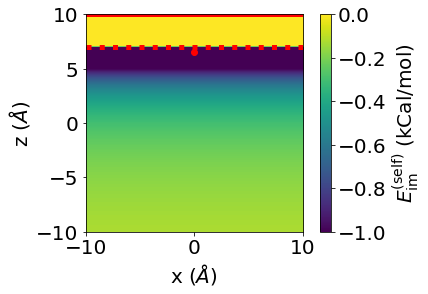

In [254]:
V_cond_self_2D = dielectric_wall_potential_self(r_2D, z_wall=z_dielectric, chi1=chi_water, chi2=chi_cond)
V_cond_self_2D = np.reshape(V_cond_self_2D, (n_x, n_z))
im = plt.imshow(V_cond_self_2D, extent=[x_min, x_max, z_min, z_max], origin='lower', aspect='equal', vmin=-1, vmax=0)
plt.colorbar(im, label='$E^{\mathrm{(self)}}_{\mathrm{im}}$ (kCal/mol)')
plt.axhline(z_wall, c='r', lw=5)
plt.axhline(z_dielectric,c='r',ls=':', lw=5)
plt.scatter(r_an[:,0], r_an[:,2], c='r')
plt.xlabel('x ($\AA$)')
plt.ylabel('z ($\AA$)')
plt.show()

Combining these we see a slightly different picture emerge for the metal-wall interface:

1. The repulsive LJ part is still present, but replacing the repulsive induced charge with an attractive one makes the regions near the interface accessible, mitigating the entropic cost of larger ion pair distances.
2. Ion pairs prefer to lie flat, parallel to the interface due to the attractive induced charges.
3. Coulomb attraction between the two species is weakened due to the increased dielectric screening by the conductor.

Overall, this should still induce a penalty on larger ion pair distances relative to the bulk but this effect should be smaller than in the case of the insulating wall.

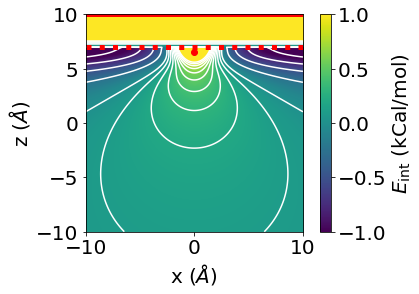

In [255]:
V_cond_int = V_cond_self_2D + V_cond_2D + V_wall_2D
im = plt.imshow(V_cond_int, extent=[x_min, x_max, z_min, z_max], origin='lower', aspect='equal', vmin=-1, vmax=1)
plt.contour(V_int, levels=[-1, -0.9, -0.8, -0.7,-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.25, 0.5,0.75,  1.0], colors='w', extent=[x_min, x_max, z_min, z_max], origin='lower', vmin=-1, vmax=1)
plt.colorbar(im, label='$E_{\mathrm{int}}$ (kCal/mol)')
plt.axhline(z_wall, c='r', lw=5)
plt.axhline(z_dielectric,c='r',ls=':', lw=5)
plt.scatter(r_an[:,0], r_an[:,2], c='r')
plt.xlabel('x ($\AA$)')
plt.ylabel('z ($\AA$)')
plt.show()

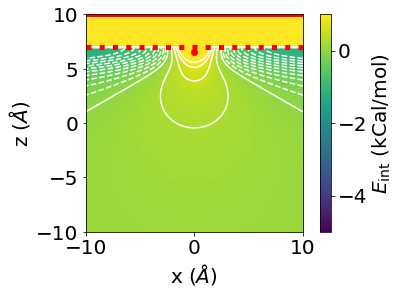

In [256]:
V_hard_cond_int = V_cond_self_2D + V_cond_2D + V_hard_wall_2D
im = plt.imshow(V_hard_cond_int, extent=[x_min, x_max, z_min, z_max], origin='lower', aspect='equal', vmin=-5, vmax=1)
plt.contour(V_hard_cond_int, levels=[-1, -0.9, -0.8, -0.7,-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.25, 0.5,0.75,  1.0], colors='w', extent=[x_min, x_max, z_min, z_max], origin='lower', vmin=-1, vmax=1)
plt.colorbar(im, label='$E_{\mathrm{int}}$ (kCal/mol)')
plt.axhline(z_wall, c='r', lw=5)
plt.axhline(z_dielectric,c='r',ls=':', lw=5)
plt.scatter(r_an[:,0], r_an[:,2], c='r')
plt.xlabel('x ($\AA$)')
plt.ylabel('z ($\AA$)')
plt.show()

In [257]:
theta_min=0
theta_max = pi
r_min=0.1
r_max=10

n_theta= 1000
n_r = 101

thetas = np.linspace(theta_min, theta_max, n_theta)
rs = np.linspace(r_min, r_max, n_r)
Rs, Thetas = np.meshgrid(rs, thetas)
X_sphere = Rs*sin(Thetas)
Z_sphere = Rs*cos(Thetas)
Y_sphere = np.zeros_like(X_sphere)
r_2D_sphere = np.reshape([X_sphere, Y_sphere, Z_sphere], (3, n_theta*n_r)).T
r_2D_sphere = r_2D_sphere + r_an
X_sphere = X_sphere+r_an[0, 0]
Y_sphere = Y_sphere+r_an[0, 1]
Z_sphere = Z_sphere+r_an[0, 2]

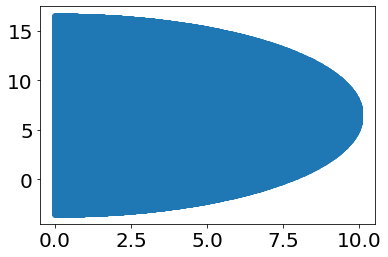

In [258]:
plt.scatter(X_sphere, Z_sphere)

In [259]:
V_wall_sphere = hard_wall_potential(r_2D_sphere, z_wall) + 1e16*(r_2D_sphere[:,2]>z_wall)
V_wall_sphere = np.reshape(V_wall_sphere, (n_theta, n_r))

(0.1, 10.0)

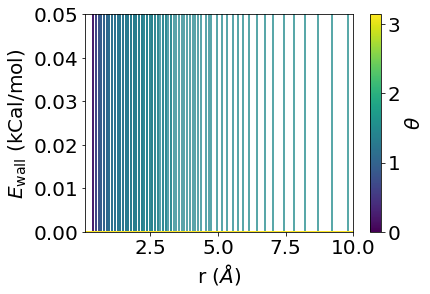

In [260]:
ax = plt.subplot()
theta_norm = Normalize(vmin=theta_min, vmax=theta_max)
theta_cmap = cm.get_cmap('viridis')
for V, th in zip(V_wall_sphere, thetas):
    ax.plot(rs, V,c=theta_cmap(theta_norm(th)))
plt.colorbar(cm.ScalarMappable(norm=theta_norm, cmap=theta_cmap), ax=ax, label=r'$\theta$')
plt.xlabel('r ($\AA$)')
plt.ylabel('$E_{\mathrm{wall}}$ (kCal/mol)')
plt.ylim(-0, 0.05)
plt.xlim(r_min, r_max)


In [261]:
V_diel_sphere = dielectric_wall_potential_other(r_2D_sphere, z_wall=z_dielectric, chi1=chi_water, r2=r_an, q2=np.array([-1])) 
V_diel_sphere = np.reshape(V_diel_sphere, (n_theta, n_r))

(0.1, 10.0)

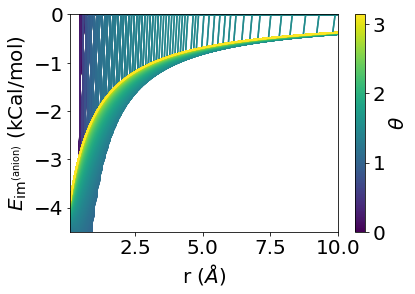

In [262]:
ax = plt.subplot()
for V, th in zip(V_diel_sphere, thetas):
    ax.plot(rs, V,c=theta_cmap(theta_norm(th)))
    ax.plot(rs, V,c=theta_cmap(theta_norm(th)))
plt.colorbar(cm.ScalarMappable(norm=theta_norm, cmap=theta_cmap), ax=ax, label=r'$\theta$')
plt.xlabel('r ($\AA$)')
plt.ylabel('$E_{\mathrm{im}^{(\mathrm{anion})}}$ (kCal/mol)')
plt.ylim(-4.5, 0)
plt.xlim(r_min, r_max)


In [263]:
V_diel_self_sphere = dielectric_wall_potential_self(r_2D_sphere, z_wall=z_dielectric, chi1=chi_water)
V_diel_self_sphere = np.reshape(V_diel_self_sphere, (n_theta, n_r))

(0.1, 10.0)

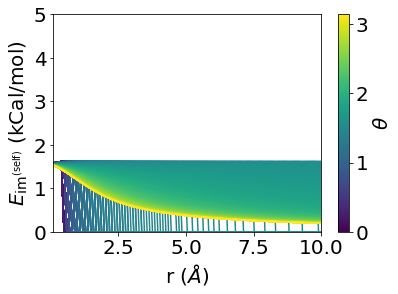

In [264]:
ax = plt.subplot()
for V, th in zip(V_diel_self_sphere, thetas):
    ax.plot(rs, V,c=theta_cmap(theta_norm(th)))
plt.colorbar(cm.ScalarMappable(norm=theta_norm, cmap=theta_cmap), ax=ax, label=r'$\theta$')
plt.xlabel('r ($\AA$)')
plt.ylabel('$E_{\mathrm{im}^{(\mathrm{self})}}$ (kCal/mol)')
plt.ylim(0, 5)
plt.xlim(r_min, r_max)


(0.1, 10.0)

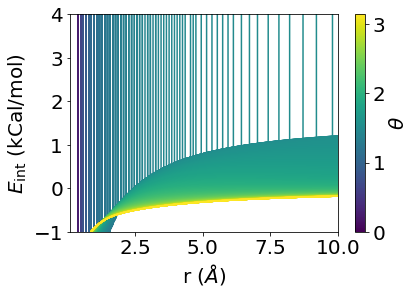

In [265]:
V_diel_int_sphere = V_wall_sphere+ V_diel_sphere + V_diel_self_sphere

ax = plt.subplot()
for V, th in zip(V_diel_int_sphere, thetas):
    ax.plot(rs, V,c=theta_cmap(theta_norm(th)))
plt.colorbar(cm.ScalarMappable(norm=theta_norm, cmap=theta_cmap), ax=ax, label=r'$\theta$')
plt.xlabel('r ($\AA$)')
plt.ylabel('$E_{\mathrm{int}}$ (kCal/mol)')
plt.ylim(-1, 4)
plt.xlim(r_min, r_max)


(0.1, 10.0)

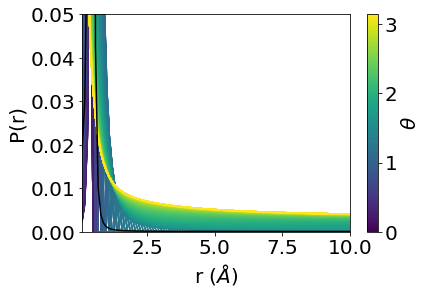

In [266]:
P_diel_int_sphere = np.exp(-V_diel_int_sphere/kT)


ax = plt.subplot()
for V, th in zip(P_diel_int_sphere, thetas):
    ax.plot(rs, V/np.sum(V),c=theta_cmap(theta_norm(th)))
plt.colorbar(cm.ScalarMappable(norm=theta_norm, cmap=theta_cmap), ax=ax, label=r'$\theta$')
P_diel_int_tot = np.sum(P_diel_int_sphere, axis=0)
P_diel_int_tot = P_diel_int_tot/np.sum(P_diel_int_tot)
ax.plot(rs, P_diel_int_tot, c='k')
plt.xlabel('r ($\AA$)')
plt.ylabel('P(r)')
plt.ylim(0, 0.05)
plt.xlim(r_min, r_max)


/var/folders/l1/h3x9q50j7593jnfkgtq065t80000gn/T/ipykernel_31206/2015085339.py:1: RuntimeWarning: divide by zero encountered in log
  F_diel_int_sphere = -kT*np.log(P_diel_int_sphere)


(0.1, 10.0)

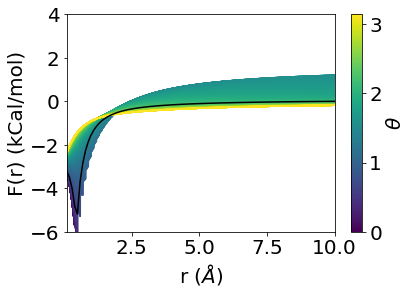

In [267]:
F_diel_int_sphere = -kT*np.log(P_diel_int_sphere)

ax = plt.subplot()
for V, th in zip(F_diel_int_sphere, thetas):
    ax.plot(rs, V,c=theta_cmap(theta_norm(th)))
plt.colorbar(cm.ScalarMappable(norm=theta_norm, cmap=theta_cmap), ax=ax, label=r'$\theta$')
F_diel_int_tot = -kT*np.log(P_diel_int_tot)
F_diel_int_tot = F_diel_int_tot-F_diel_int_tot[-1]
ax.plot(rs, F_diel_int_tot, c='k')
plt.xlabel('r ($\AA$)')
plt.ylabel('F(r) (kCal/mol)')
plt.ylim(-6, 4)
plt.xlim(r_min, r_max)


(0.1, 10.0)

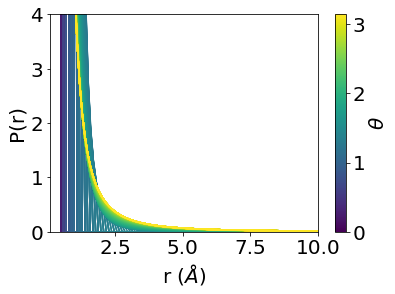

In [268]:
ax = plt.subplot()
for V, th in zip(P_diel_int_sphere, thetas):
    V=V/rs**2
    ax.plot(rs, V,c=theta_cmap(theta_norm(th)))
plt.colorbar(cm.ScalarMappable(norm=theta_norm, cmap=theta_cmap), ax=ax, label=r'$\theta$')
plt.xlabel('r ($\AA$)')
plt.ylabel('P(r)')
plt.ylim(0, 4)
plt.xlim(r_min, r_max)

In [269]:
V_cond_sphere = dielectric_wall_potential_other(r_2D_sphere, z_wall=z_dielectric, chi1=chi_water,chi2=chi_cond, r2=r_an, q2=np.array([-1])) 
V_cond_sphere = np.reshape(V_cond_sphere, (n_theta, n_r))
V_cond_self_sphere = dielectric_wall_potential_self(r_2D_sphere, z_wall=z_dielectric, chi1=chi_water, chi2=chi_cond)
V_cond_self_sphere = np.reshape(V_cond_self_sphere, (n_theta, n_r))
V_cond_int_sphere = V_wall_sphere+ V_cond_sphere + V_cond_self_sphere

(0.1, 10.0)

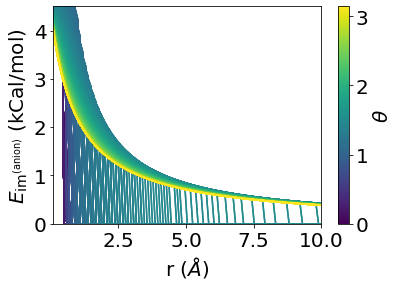

In [270]:
ax = plt.subplot()
for V, th in zip(V_cond_sphere, thetas):
    ax.plot(rs, V,c=theta_cmap(theta_norm(th)))
    ax.plot(rs, V,c=theta_cmap(theta_norm(th)))
plt.colorbar(cm.ScalarMappable(norm=theta_norm, cmap=theta_cmap), ax=ax, label=r'$\theta$')
plt.xlabel('r ($\AA$)')
plt.ylabel('$E_{\mathrm{im}^{(\mathrm{anion})}}$ (kCal/mol)')
plt.ylim(0, 4.5)
plt.xlim(r_min, r_max)

(0.1, 10.0)

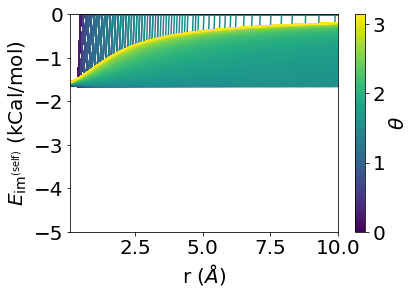

In [271]:
ax = plt.subplot()
for V, th in zip(V_cond_self_sphere, thetas):
    ax.plot(rs, V,c=theta_cmap(theta_norm(th)))
plt.colorbar(cm.ScalarMappable(norm=theta_norm, cmap=theta_cmap), ax=ax, label=r'$\theta$')
plt.xlabel('r ($\AA$)')
plt.ylabel('$E_{\mathrm{im}^{(\mathrm{self})}}$ (kCal/mol)')
plt.ylim(-5, 0)
plt.xlim(r_min, r_max)

(0.1, 10.0)

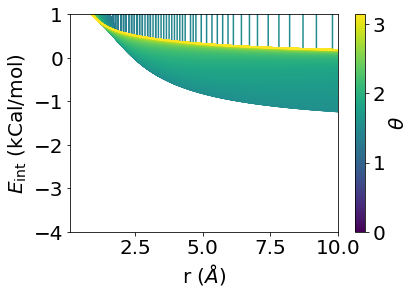

In [272]:
ax = plt.subplot()
for V, th in zip(V_cond_int_sphere, thetas):
    ax.plot(rs, V,c=theta_cmap(theta_norm(th)))
plt.colorbar(cm.ScalarMappable(norm=theta_norm, cmap=theta_cmap), ax=ax, label=r'$\theta$')
plt.xlabel('r ($\AA$)')
plt.ylabel('$E_{\mathrm{int}}$ (kCal/mol)')
plt.ylim(-4, 1)
plt.xlim(r_min, r_max)


(0.1, 10.0)

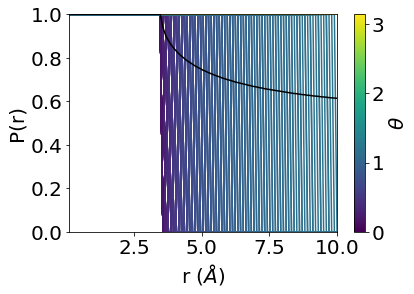

In [275]:
#P_cond_int_sphere = np.exp(-V_cond_int_sphere/kT) * (Z_sphere<z_wall)
P_cond_int_sphere = (Z_sphere<z_wall)

ax = plt.subplot()
for V, th in zip(P_cond_int_sphere, thetas):
    ax.plot(rs, V/np.max(V),c=theta_cmap(theta_norm(th)))
plt.colorbar(cm.ScalarMappable(norm=theta_norm, cmap=theta_cmap), ax=ax, label=r'$\theta$')
P_cond_int_tot = np.sum(P_cond_int_sphere, axis=0)
P_cond_int_tot = P_cond_int_tot/np.max(P_cond_int_tot)
ax.plot(rs, P_cond_int_tot, c='k')
plt.xlabel('r ($\AA$)')
plt.ylabel('P(r)')
plt.ylim(0,1)
plt.xlim(r_min, r_max)


/var/folders/l1/h3x9q50j7593jnfkgtq065t80000gn/T/ipykernel_31206/2230823913.py:1: RuntimeWarning: divide by zero encountered in log
  F_cond_int_sphere = -kT*np.log(P_cond_int_sphere)


(0.1, 10.0)

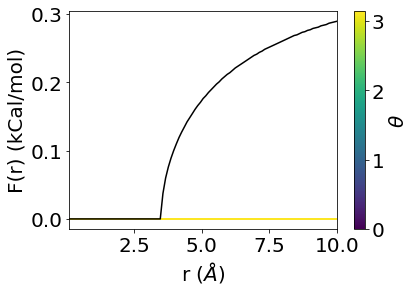

In [276]:
F_cond_int_sphere = -kT*np.log(P_cond_int_sphere)

ax = plt.subplot()
for V, th in zip(F_cond_int_sphere, thetas):
    ax.plot(rs, V,c=theta_cmap(theta_norm(th)))
plt.colorbar(cm.ScalarMappable(norm=theta_norm, cmap=theta_cmap), ax=ax, label=r'$\theta$')
F_cond_int_tot = -kT*np.log(P_cond_int_tot)
F_cond_int_tot = F_cond_int_tot
ax.plot(rs, F_cond_int_tot, c='k')
plt.xlabel('r ($\AA$)')
plt.ylabel('F(r) (kCal/mol)')
plt.xlim(r_min, r_max)